## Dead Reckoning Steps

Dead reckoning is a navigation method that estimates the current position of an object based on a previously known position, combined with estimates of the direction and distance traveled. 

1) Integration of Linear Accelerations obtained from IMU to obtain velocity
2) Integration of Velocity to obtain position
3) Yaw Calculation from Quaternion components (orientation.x, orientation.y, orientation.z, orientation.w)
4) Velocity Detrending Before and After Adjustment using unbiased linear acceleration values
5)  Integration of Velocities for Distance Calculation
6) Path Generation by Dead Reckoning

In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np

### Please upload the rosbag here

In [2]:
b = bagreader("filter.bag")
# # get the list of topics
# print(b.topic_table)

In [3]:
imu_data = b.message_by_topic('/imu/imu_uncompensated')
gps_data = b.message_by_topic('/gps/fix')

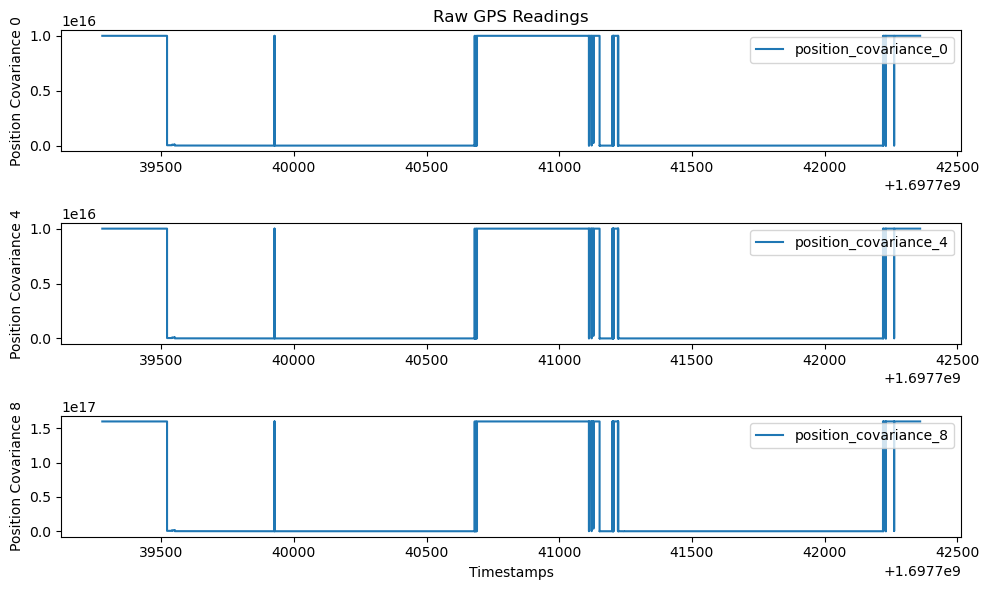

In [4]:
# gps_data = "E:/filters/filter/gps-fix.csv"

# Load the data into a pandas DataFrame
raw_gps_data = pd.read_csv(gps_data)

# Extract columns
timestamps = raw_gps_data['header.stamp.secs']
position_covariance_0 = raw_gps_data['position_covariance_0']
position_covariance_4 = raw_gps_data['position_covariance_4']
position_covariance_8 = raw_gps_data['position_covariance_8']

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(timestamps, position_covariance_0, label='position_covariance_0')
plt.title('Raw GPS Readings')
plt.ylabel('Position Covariance 0')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(timestamps, position_covariance_4, label='position_covariance_4')
plt.ylabel('Position Covariance 4')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(timestamps, position_covariance_8, label='position_covariance_8')
plt.xlabel('Timestamps')
plt.ylabel('Position Covariance 8')
plt.legend()

plt.tight_layout()
plt.show()

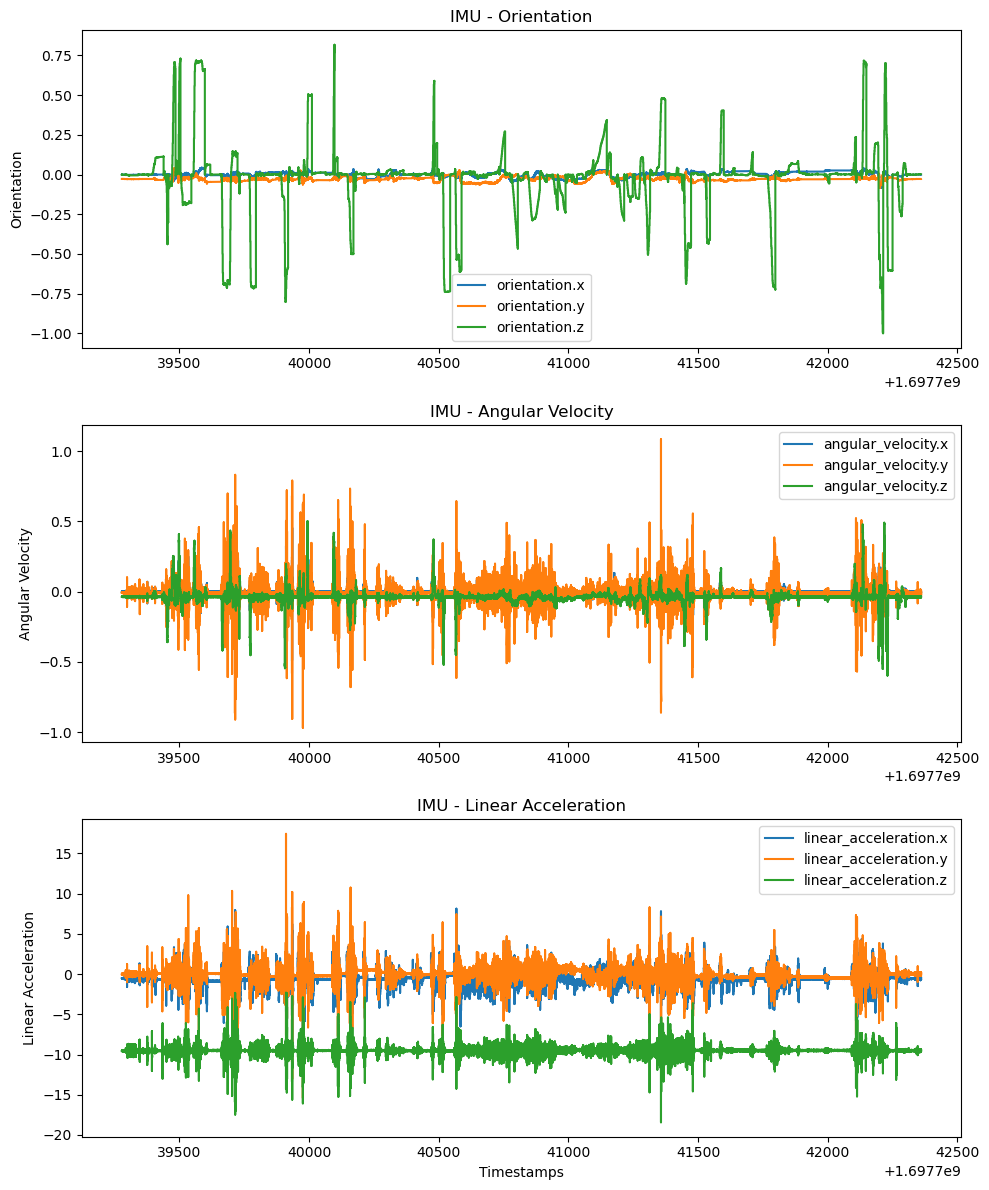

In [5]:
# Load the data into a pandas DataFrame
# imu_data = pd.read_csv("E:/filters/filter/imu-imu_uncompensated.csv")
imu_data = pd.read_csv(imu_data)

# Extract columns
timestamps_imu = imu_data['header.stamp.secs']
orientation_x = imu_data['orientation.x']
orientation_y = imu_data['orientation.y']
orientation_z = imu_data['orientation.z']
angular_velocity_x = imu_data['angular_velocity.x']
angular_velocity_y = imu_data['angular_velocity.y']
angular_velocity_z = imu_data['angular_velocity.z']
linear_acceleration_x = imu_data['linear_acceleration.x']
linear_acceleration_y = imu_data['linear_acceleration.y']
linear_acceleration_z = imu_data['linear_acceleration.z']

# Plotting
plt.figure(figsize=(10, 12))

# Plot orientation
plt.subplot(3, 1, 1)
plt.plot(timestamps_imu, orientation_x, label='orientation.x')
plt.plot(timestamps_imu, orientation_y, label='orientation.y')
plt.plot(timestamps_imu, orientation_z, label='orientation.z')
plt.title('IMU - Orientation')
plt.ylabel('Orientation')
plt.legend()

# Plot angular velocity
plt.subplot(3, 1, 2)
plt.plot(timestamps_imu, angular_velocity_x, label='angular_velocity.x')
plt.plot(timestamps_imu, angular_velocity_y, label='angular_velocity.y')
plt.plot(timestamps_imu, angular_velocity_z, label='angular_velocity.z')
plt.title('IMU - Angular Velocity')
plt.ylabel('Angular Velocity')
plt.legend()

# Plot linear acceleration
plt.subplot(3, 1, 3)
plt.plot(timestamps_imu, linear_acceleration_x, label='linear_acceleration.x')
plt.plot(timestamps_imu, linear_acceleration_y, label='linear_acceleration.y')
plt.plot(timestamps_imu, linear_acceleration_z, label='linear_acceleration.z')
plt.xlabel('Timestamps')
plt.title('IMU - Linear Acceleration')
plt.ylabel('Linear Acceleration')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import utm
import pandas as pd

# Define the coordinate conversion function
def convert_latlon_to_utm(lat, lon):
    # Check if the latitude or longitude is NaN
    if pd.isna(lat) or pd.isna(lon):
        return None, None
    
    # Convert latitude and longitude to UTM
    easting, northing, _, _ = utm.from_latlon(lat, lon)

    return easting, northing

# Apply the conversion function to the DataFrame
raw_gps_data['easting'], raw_gps_data['northing'] = zip(*raw_gps_data.apply(lambda row: convert_latlon_to_utm(row['latitude'], row['longitude']), axis=1))


In [9]:
import plotly.express as px

# Create a 2D scatter plot
fig = px.scatter(raw_gps_data, x='easting', y='northing',
                 title='GPS Trajectory',
                 labels={'easting': 'Easting', 'northing': 'Northing', 'altitude': 'Altitude'})

# Show the interactive plot
fig.show()


In [10]:
delta_easting = np.diff(raw_gps_data['easting'])
delta_northing = np.diff(raw_gps_data['northing'])

# Calculate angles using arctan2
angles = np.arctan2(delta_northing, delta_easting)

angles =  np.insert(angles, 0, 0)
raw_gps_data['Angles'] = angles

In [11]:
# timestamps_imu = imu_data['header.stamp.secs']
angular_velocity = imu_data[['angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']].values
linear_acceleration = imu_data[['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']].values
orientation_imu = imu_data[['orientation.x', 'orientation.y', 'orientation.z']].values

In [13]:
# Define the range for which you want to calculate the mean
start_index = 0
end_index = 54697

# Calculate mean values for each axis within the specified range
mean_values = np.mean(linear_acceleration[start_index:end_index, :], axis=0)

# Subtract mean values from the entire dataset
linear_acceleration_adjusted = linear_acceleration - mean_values

In [14]:
# Define the range for which you want to calculate the mean

# Calculate mean values for each axis within the specified range
mean_values_vel = np.mean(angular_velocity[start_index:end_index, :], axis=0)

# Subtract mean values from the entire dataset
angular_velocity_adjusted = angular_velocity - mean_values_vel

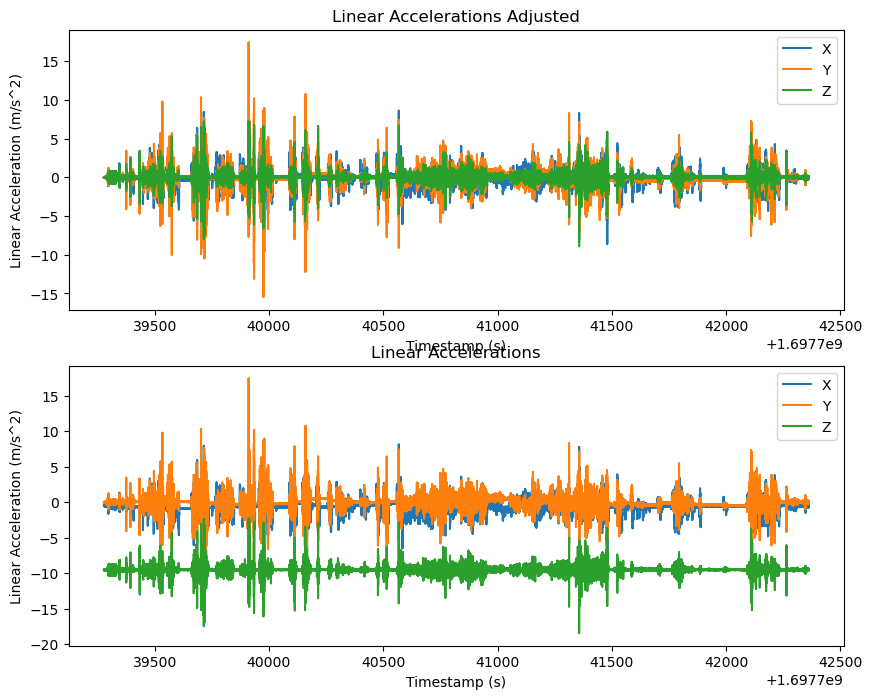

In [15]:
# Increase Figure Size
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
# Plot Linear Accelerations
plt.plot(timestamps_imu, linear_acceleration_adjusted)
plt.title('Linear Accelerations Adjusted')
plt.xlabel('Timestamp (s)')
plt.ylabel('Linear Acceleration (m/s^2)')
plt.legend(['X', 'Y', 'Z'])

# Plot Linear Accelerations
plt.subplot(2, 1, 2)
plt.plot(timestamps_imu, linear_acceleration)
plt.title('Linear Accelerations')
plt.xlabel('Timestamp (s)')
plt.ylabel('Linear Acceleration (m/s^2)')
plt.legend(['X', 'Y', 'Z'])

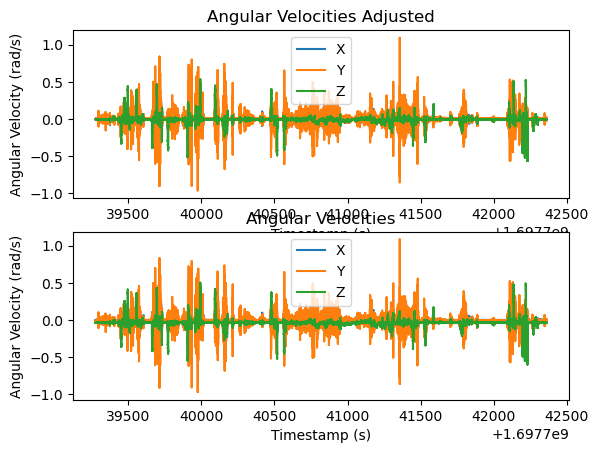

In [16]:
# Plot Angular Velocities
plt.subplot(2, 1, 1)
plt.plot(timestamps_imu, angular_velocity_adjusted)
plt.title('Angular Velocities Adjusted')
plt.xlabel('Timestamp (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend(['X', 'Y', 'Z'])

# Plot Angular Velocities
plt.subplot(2, 1, 2)
plt.plot(timestamps_imu, angular_velocity)
plt.title('Angular Velocities')
plt.xlabel('Timestamp (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend(['X', 'Y', 'Z'])

In [17]:
imu_data['angular_velocity_adjusted_Z'] = angular_velocity_adjusted[:, 2]
imu_data['linear_acceleration_X'] = linear_acceleration_adjusted[:,0]
imu_data['linear_acceleration_Y'] = linear_acceleration_adjusted[:,1]


In [18]:
from scipy import integrate
gyro_yaw= imu_data["angular_velocity_adjusted_Z"].to_numpy()
yaw_from_gyro=integrate.cumtrapz(gyro_yaw,timestamps_imu,initial=gyro_yaw[0])
# Integrate linear accelerations to obtain velocity using cumtrapz
velocity_adjusted = integrate.cumtrapz(imu_data['linear_acceleration.x'], initial=0)

# Integrate velocity to obtain position using cumtrapz
position_adjusted = integrate.cumtrapz(velocity_adjusted, initial=0)

<Axes: xlabel='header.stamp.secs'>

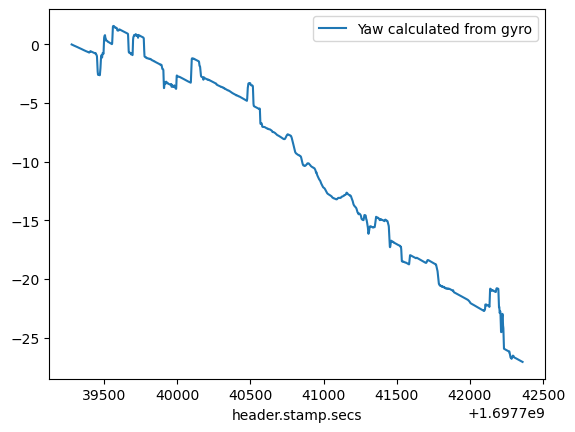

In [19]:
import seaborn as sns

sns.lineplot(x=timestamps_imu,y=yaw_from_gyro,label='Yaw calculated from gyro',errorbar=None)

<Axes: xlabel='header.stamp.secs'>

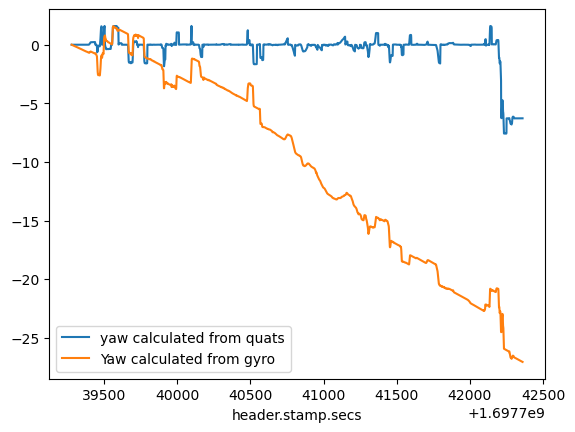

In [20]:
x=imu_data['orientation.x']
y=imu_data['orientation.y']
z=imu_data['orientation.z']
w=imu_data['orientation.w']

yaw_quat = np.arctan2(2*(x*y + z*w), 1-2*(y**2 + z**2))
yaw_quat=np.unwrap(yaw_quat)
sns.lineplot(x=timestamps_imu,y=yaw_quat,label="yaw calculated from quats",errorbar=None)
sns.lineplot(x=timestamps_imu,y=yaw_from_gyro,label='Yaw calculated from gyro',errorbar=None)

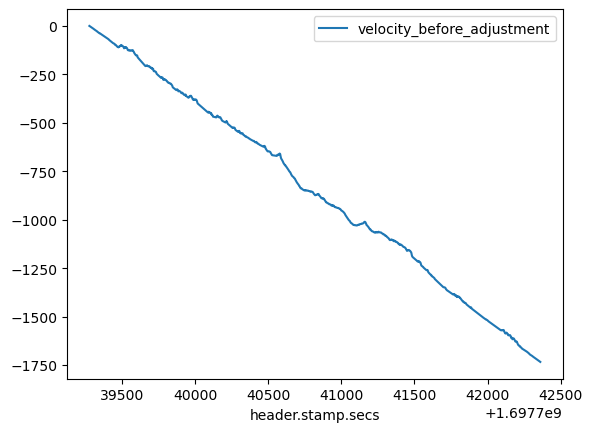

In [21]:
from scipy.signal import butter, filtfilt,detrend
dt_imu_new = np.diff(timestamps_imu)

detrend_velo_before=integrate.cumtrapz(imu_data["linear_acceleration.x"],dx=dt_imu_new,initial=imu_data["linear_acceleration.x"][0])
sns.lineplot(x=timestamps_imu,y=detrend_velo_before,label='velocity_before_adjustment',errorbar=None)

detrend_velo_after=integrate.cumtrapz(linear_acceleration_adjusted[:,0],dx=dt_imu_new,initial=linear_acceleration_adjusted[:,0][0])
detrend_velo_after=detrend(detrend_velo_after)
detrend_velo_after=detrend_velo_after-1.5
scale=np.ones_like(detrend_velo_after)
detrend_velo_after[scale==0]=0
detrend_velo_after[detrend_velo_after<0]=0
# sns.lineplot(x=timestamps_imu,y=detrend_velo_after,label='velocity_after_adjustment',errorbar=None)



30757
30757
30757
30757


C:\Users\Avnish\AppData\Local\Temp\ipykernel_1156\771307857.py:7: RuntimeWarning:

divide by zero encountered in divide

C:\Users\Avnish\AppData\Local\Temp\ipykernel_1156\771307857.py:7: RuntimeWarning:

invalid value encountered in divide

C:\Users\Avnish\AppData\Local\Temp\ipykernel_1156\771307857.py:9: RuntimeWarning:

divide by zero encountered in divide

C:\Users\Avnish\AppData\Local\Temp\ipykernel_1156\771307857.py:9: RuntimeWarning:

invalid value encountered in divide



Text(0, 0.5, 'Velocity m/s')

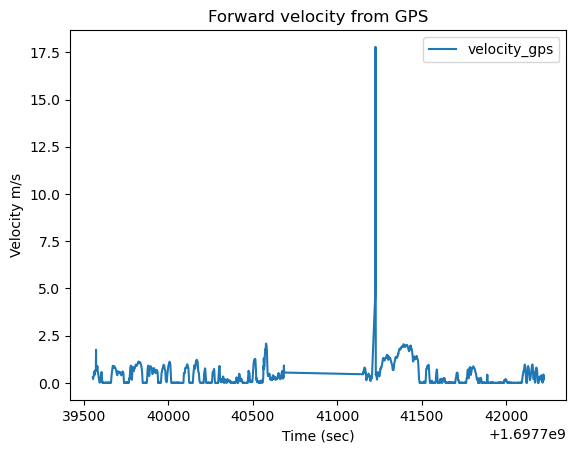

In [22]:
timestamps_gps = raw_gps_data['header.stamp.secs']
dt_gps= np.diff(timestamps_gps)
# dt_gps = np.insert(dt_gps, 0, 0)
print(len(dt_gps))
print(len(delta_easting))
# Calculate velocities
velocity_easting = delta_easting / dt_gps
print(len(velocity_easting))
velocity_northing = delta_northing / dt_gps

# Calculate total velocity

total_velocity = np.sqrt(velocity_easting**2 + velocity_northing**2)

# raw_gps_data['Total_Velocity'] = total_velocity
sns.lineplot(x=timestamps_gps[1:],y=total_velocity,label='velocity_gps',errorbar=None)
plt.xlabel('Time (sec)')
plt.title("Forward velocity from GPS")
plt.ylabel("Velocity m/s")

Text(0, 0.5, 'Velocity m/s')

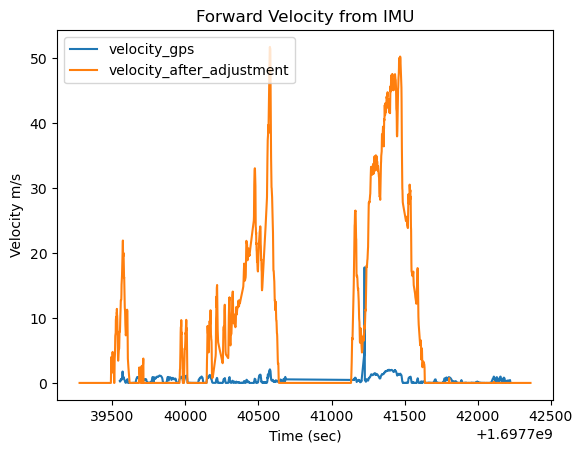

In [24]:
sns.lineplot(x=timestamps_gps[1:],y=total_velocity,label='velocity_gps',errorbar=None)
plt.xlabel('Time (sec)')
plt.title("Forward velocity from GPS")
plt.ylabel("Velocity m/s")

sns.lineplot(x=timestamps_imu,y=detrend_velo_after,label='velocity_after_adjustment',errorbar=None)
plt.xlabel('Time (sec)')
plt.title("Forward Velocity from IMU")
plt.ylabel("Velocity m/s")

In [25]:
imu_dist=integrate.cumtrapz(detrend_velo_after,dx=0.005,initial=detrend_velo_after[0])
# gps_dist=integrate.cumtrapz(total_velocity,dx=0.1,initial=total_velocity[0])

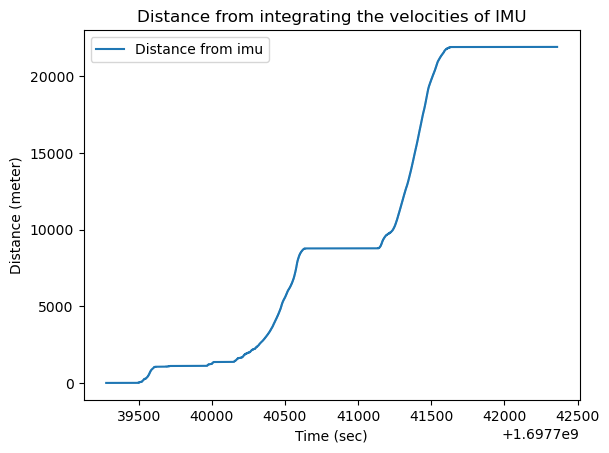

In [26]:
# print(gps_dist.shape,timestamps_gps[1:].shape)
# print(imu_dist.shape,timestamps_imu.shape)

# Plotting using Matplotlib
plt.plot(timestamps_imu, imu_dist, label='Distance from imu')
plt.title('Distance from integrating the velocities of IMU')
plt.xlabel('Time (sec)')
plt.ylabel('Distance (meter)')
plt.legend()
plt.show()

Text(0, 0.5, 'Northing (meter)')

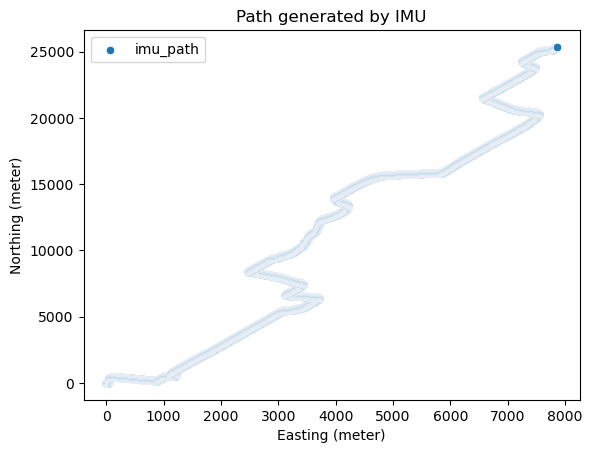

In [27]:
Velo_N=np.cos(yaw_quat-0.4)*detrend_velo_after -np.sin(yaw_quat-0.4)*detrend_velo_after
Velo_E=np.sin(yaw_quat-0.4)*detrend_velo_after +np.cos(yaw_quat-0.4)*detrend_velo_after
X_E=integrate.cumtrapz(Velo_E,dx=0.005,initial=Velo_E[0])
X_N=integrate.cumtrapz(Velo_N,dx=0.005,initial=Velo_N[0])

sns.scatterplot(x=X_E,y=X_N,label="imu_path")


plt.title('Path generated by IMU')
plt.xlabel('Easting (meter)')
plt.ylabel('Northing (meter)')



## Kalman Filter

1) Initialization: Start with an initial state estimate (x) and covariance matrix (P) representing the uncertainty in the initial estimate.
2) Prediction Step:

a) Use a process model to predict the next state (x) based on the current state and control input (u_k).
This step involves predicting where the system should be in the next time step. \
b) Update the covariance matrix (P) to account for the uncertainty introduced during the prediction.

3) Measurement Update Step:

a) Obtain measurements (z) from sensors, which may contain noise. \
b) Compute the residual (y), the difference between the predicted state (x) and the actual measurement (z). \
c) Compute the Kalman gain (K), which determines how much the prediction should be adjusted based on the difference between prediction and measurement. \
d) Update the state estimate (x) using the Kalman gain and the residual. \
e) Update the covariance matrix (P) to reflect the reduced uncertainty after incorporating the measurements.

In [28]:
def process_model(state, dt, u_k):
    x, y, theta, v_x, v_y = state.flatten()
    a_x, a_y, omega = u_k.T

    # Update state
    theta_new = theta + omega * dt
    v_x_new = v_x + a_x * dt
    v_y_new = v_y + a_y * dt
    x_new = x + v_x_new * dt
    y_new = y + v_y_new * dt

    return np.array([x_new, y_new, theta_new, v_x_new, v_y_new])

def update(state, P, z, R, H):

    x, y, theta, _, _ =  state.flatten()
    y = z - np.array([x,y,theta])

    S = H @ P @ H.T + R  
    K = P @ H.T @ np.linalg.inv(S)  # Kalman Gain
    state = state + K @ y  
    P = P - K @ H @ P  
    return state, P


def predict(state, P, dt, u_k, Q):

    _, _, theta, v_x, v_y = state.flatten()

    F = np.array([[1, 0, -v_x * np.sin(theta) * dt - v_y * np.cos(theta) * dt, dt, 0],  #x
                [0, 1, v_x * np.cos(theta) * dt - v_y * np.sin(theta) * dt, 0, dt],     #y
                [0, 0, 1, 0, 0],                                                        #theta
                [0, 0, 0, 1, 0],                                                        #vel_x
                [0, 0, 0, 0, 1]])                                                       #vel_y
    state = process_model(state, dt, u_k)
    P = F @ P @ F.T + Q
    return state, P

In [29]:
Q1 = np.diag([0.1]*5)

forward_velocity_noise_std = detrend_velo_after.std()
yaw_rate_noise_std = yaw_quat.std()

R = np.diag([forward_velocity_noise_std ** 2., forward_velocity_noise_std ** 2., yaw_rate_noise_std ** 2.])

Q2 = np.diag([0.001]*5)

# Initial state and covariance
x_hat = np.zeros(5) 
P = np.eye(5) * 0.1  

# EKF Steps
H = np.array([
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0]
    ])


cov_x = np.zeros(len(timestamps_gps))
cov_y = np.zeros(len(timestamps_gps))
cov_theta = np.zeros(len(timestamps_gps))

updated_northing = []
updated_easting = []

updated_northing_cov = []  
updated_easting_cov = []   
updated_theta_cov = []  

dt_imu=0.005

gps_easting_cov = raw_gps_data['position_covariance_0']

for t in range(2737, len(timestamps_gps)):
    if not np.isnan(raw_gps_data['easting'][t]):

        if(gps_easting_cov[t] < 700): # Dynamic Q and R
            Q = Q1
            R = R
        else:
            Q = Q2
            R = R
            
        mean_acc_x = linear_acceleration_adjusted[:,0][t*20:(t+1)*20].mean()
        mean_acc_y = linear_acceleration_adjusted[:,1][t*20:(t+1)*20].mean()
        mean_angular_z = angular_velocity_adjusted[:, 2][t*20:(t+1)*20].mean()
        

        measurements = np.array([mean_acc_x,mean_acc_y,mean_angular_z]) 

        x_hat, P = predict(x_hat, P, dt_imu, measurements, Q)

        z = [raw_gps_data['northing'][t],raw_gps_data['easting'][t],yaw_quat[t]]
        x_hat, P = update(x_hat, P, z, R, H)
        # Store covariances
        cov_x[t] = P[0, 0]
        cov_y[t] = P[1, 1]
        cov_theta[t] = P[2, 2]

        updated_northing.append(x_hat[0])
        updated_easting.append(x_hat[1])
        
        updated_northing_cov.append(cov_x[t])
        updated_easting_cov.append(cov_y[t])
        updated_theta_cov.append(cov_theta[t])

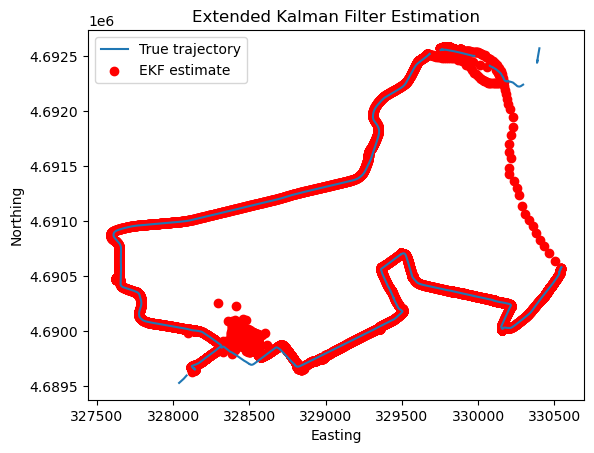

In [30]:
# # Plot True Trajectory

plt.plot(raw_gps_data['easting'], raw_gps_data['northing'], label='True trajectory')
plt.scatter(updated_easting[80:], updated_northing[80:], label='EKF estimate', marker='o', color='red')  # Use scatter plot
plt.title('Extended Kalman Filter Estimation')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.legend()

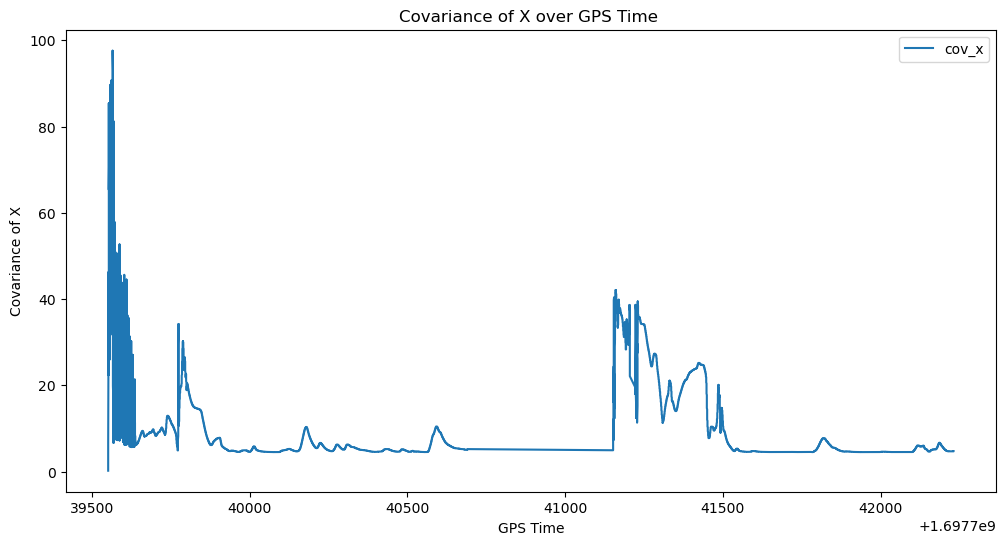

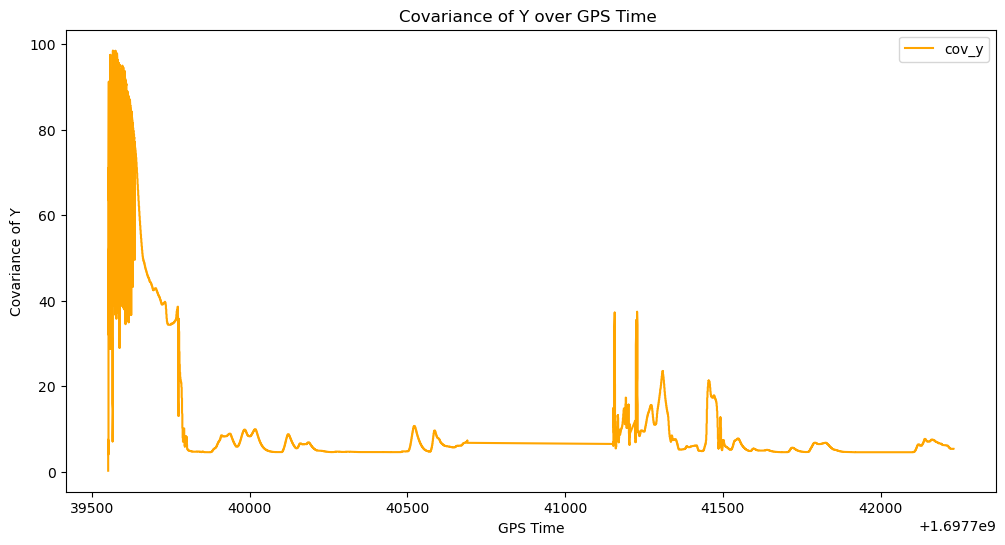

In [43]:
import matplotlib.pyplot as plt

# Assuming timestamps_gps is a list of timestamps corresponding to your data points

# Get the indices of non-NaN easting values
non_nan_indices = ~np.isnan(raw_gps_data['easting'])

# Plot cov_x for non-NaN values of easting
plt.figure(figsize=(12, 6))
plt.plot(np.array(timestamps_gps)[non_nan_indices][:21869], np.array(updated_northing_cov), label='cov_x')
plt.xlabel('GPS Time')
plt.ylabel('Covariance of X')
plt.title('Covariance of X over GPS Time ')
plt.legend()
plt.show()

# Plot cov_y for non-NaN values of easting
plt.figure(figsize=(12, 6))
plt.plot(np.array(timestamps_gps)[non_nan_indices][:21869], np.array(updated_easting_cov), label='cov_y', color='orange')
plt.xlabel('GPS Time')
plt.ylabel('Covariance of Y')
plt.title('Covariance of Y over GPS Time ')
plt.legend()
plt.show()


## Results Analysis

1. The Kalman filter gives us a rough estimate of the position taken in the tunnels where the GPS does not work and we have to rely on the IMU measurements
2. The estimate is not exactly correct as the tunnel path was not perfectly linear
3. This error in the estimate may be due to the system initial modelling of states and different covariance matrices. There is also lots of bias in linear acceleration and also due to accumulation of yaws
4. The covariance in x and y indicate that when there are NAN gps values due to the vehicle moving inside a tunnel in the latter part of the graph, there is a high covariance otherwise low covariance when the vehicle is moving freely on the road.